ChEn-3170: Computational Methods in Chemical Engineering Spring 2024 UMass Lowell; Prof. V. F. de Almeida **26Mar24**

# 14. Single Reaction at Equilibrium
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{x}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\abs}[1]{\left\lvert{#1}\right\rvert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \DeclareMathOperator{\gradx}{\nabla\!_{\xvec}}
  \newcommand{\Kcal}{\mathcal{K}}
$

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Algorithm](#algo)
* [Input Data 1](#data1)
  - [Plot Equilibrium Function](#pef1)
  - [Solve for Equilibrium](#solve1)
  - [Plot Equilibrium Point](#pep1)
* [Input Data 2](#data2)
  - [Plot Equilibrium Function](#pef2)
  - [Solve for Equilibrium](#solve2)
  - [Plot Equilibrium Point](#pep2)
* [Input Data 3](#data3)
  - [Plot Equilibrium Function](#pef3)
  - [Solve for Equilibrium](#solve3)
  - [Plot Equilibrium Point](#pep3)
---

## [Introduction](#toc)<a id="intro"></a>
In the previous [notebook](https://nbviewer.jupyter.org/github/dpploy/chen-3170/blob/master/notebooks/13-nonlinear-root-finding.ipynb), an algorithm was developed for finding the equilibrium molar fractions of a single reversible chemical reaction with a fixed stoichiometry and fixed number of chemical species. Here we expand
Newton's method for computing roots of a single non-linear equation, $\Kcal\bigl(\xvec(\widehat{\varepsilon})\bigr)=0$, for **variable stoichiometry and variable number of chemical species**, described in the course notes OneNote [ChEn-3170-nonlinalg-b](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Ejy2vb3i-_tFiIiDN3SieIYBizLV1e8w2pVDgjLCWe4Rsw?e=xaW3U6).

The task at hand is to compute the equilibrium molar fraction of species undergoing a reversible reaction for an arbitrary number of species and an arbitrary stoichiometry, say

\begin{equation*}
\nu_A\,\text{A} + \nu_B\,\text{B} \overset{K_x}{\longleftrightarrow} \nu_C\,\text{C} + \nu_D\,\text{D}    ,
\end{equation*}

that is, compute $x_A$, $x_B$, $x_C$, $x_D$ for the given stoichiometry and molar equilibrium reaction constant $K_x$. Note that this information is not sufficient for computing the equilibrium molar fraction. In addition, it is required that the molar fraction of **any three species is known** at some point in time or as a reference, say $x_{A_0}$, $x_{B_0}$, and $x_{C_0}$; note $x_{A_0} + x_{B_0} + x_{C_0} + x_{D_0}= 1$.

In this case we write the equilibrium function as

\begin{equation*}
\Kcal\bigl(\xvec\bigr)= K_x - \prod\limits_{j=\text{A,B,C,D}}\, x_j^{S_{1,j}} = 0,
\end{equation*}

where the molar fraction vector is defined as $\xvec = (x_A, x_B, x_C, x_c)$, the first row of elements of the stoichiometric matrix is denoted as ${S_{1,j}}$. This form of the equilibrium equation holds for any reversible chemical reaction by extending the product of powers of the molar fractions. Therefore a general solution method will result from adopting this particular form of a reaction equilibrium function.

In [1]:
'''Function: Equilibrium function'''

def keq_function(x_vec, eq_kx_cte, stoic_mtrx):
    
    stoic_row = stoic_mtrx[0,:]
    
    value = eq_kx_cte - x_vec[0]**stoic_row[0] * x_vec[1]**stoic_row[1] \
                        * x_vec[2]**stoic_row[2] * x_vec[3]**stoic_row[3]
    
    return value

The molar fractions vector are a function of the normalized extent of reaction

\begin{equation*}
\xvec(\widehat{\varepsilon}) = \frac{\xvec^{(0)} + \widehat{\varepsilon}\,\Smtrx^\top_{\bullet,1}}{1+\widehat{\varepsilon}\sum\limits_j S^\top_{j,1}} ,
\end{equation*}

where $\xvec^{(0)} = (x_{A_0}, x_{B_0}, x_{C_0}, x_{D_0})$.

In [2]:
'''Function: Molar fractions function'''

def molar_fractions(ext_hat, x_vec_0, stoic_mtrx):
    
    stoic_row = stoic_mtrx[0,:]
    
    # Sanity check
    assert abs(x_vec_0.sum()-1.0) <= 1e-10
    assert abs(1.0 + ext_hat * stoic_row.sum()) >= 1e-8
    
    x_vec = (x_vec_0 + ext_hat * stoic_row) / \
            (1.0 + ext_hat * stoic_row.sum())
    
    return x_vec

The usage of Newton's method to compute an equilibrium molar fraction solution requires the value of 
$\Kcal\bigl(\xvec(\widehat{\varepsilon})\bigr)$ at different values of $\widehat{\varepsilon}$ and the total derivative

\begin{equation*}
d_{\widehat{\varepsilon}} \Kcal\bigl(\xvec(\widehat{\varepsilon})\bigr) = 
                       \gradx\Kcal \cdot d_{\widehat{\varepsilon}}\xvec
\end{equation*}

where the molar fraction gradient is 

\begin{equation*}
 \gradx\Kcal = - 
  K_x \begin{pmatrix} 
       S_{1,A}\,x_A^{-1} \\ 
       S_{1,B}\,x_B^{-1} \\
       S_{1,C}\,x_C^{-1} \\
       S_{1,D}\,x_D^{-1} 
       \end{pmatrix} .
\end{equation*}

In [3]:
'''Function: Gradient wrt molar fractions of the equilibrium function'''

def grad_x_keq_function(x_vec, eq_kx_cte, stoic_mtrx):
    
    stoic_row = stoic_mtrx[0,:]
    
    import numpy as np
    x_vec_local = np.copy(x_vec)
    
    # Correct for division by a very small number (null products)
    max_x = x_vec_local.max()
    
    for i in range(x_vec_local.size):
        if x_vec_local[i] < 1e-8:
            x_vec_local[i] = max_x # some reasonable mole fraction
            
    x_vec_inv = 1.0/x_vec_local
    
    grad_vec = - eq_kx_cte * stoic_row * x_vec_inv
    
    return grad_vec

The molar fraction derivative is

\begin{equation*}
  d_{\widehat{\varepsilon}}\xvec = \frac{\Smtrx^\top_{\bullet,1} - \xvec^{(0)}\,\sum_j S^\top_{j,1}}
                                { \bigl(1 + \widehat{\varepsilon}\,\sum_j S^\top_{j,1}\bigr)^2 } .
\end{equation*}


In [4]:
'''Function: Derivative of the molar fractions function wrt normalized extent of reaction'''

def d_ext_molar_fractions(ext_hat, x_vec_0, stoic_mtrx):
    
    stoic_row = stoic_mtrx[0,:]
    
    dext_x_vec = (stoic_row - x_vec_0 * stoic_row.sum()) / \
                 (1.0 + ext_hat * stoic_row.sum())**2
    
    return dext_x_vec

## [Algorithm](#toc)<a id="algo"></a>

Given $\Kcal\bigl(\xvec(\widehat{\varepsilon})\bigr)$, find the root

\begin{equation*}
\Kcal\bigl(\xvec(\widehat{\varepsilon})\bigr) = 0 ,
\end{equation*}

using an iterative method based on the initial guess $\widehat{\varepsilon}_0$. Compute the updates

\begin{equation*}
\delta \widehat{\varepsilon}_k = - \frac{ \Kcal\bigl(\xvec(\widehat{\varepsilon}_{k-1})\bigr)}
                                     {d_{\widehat{\varepsilon}}\Kcal\bigl(\xvec(\widehat{\varepsilon}_{k-1})\bigr)} 
                                     \ \qquad \  \forall \ \qquad \ k = 1,\ldots,k_\text{max} , 
\end{equation*}

then compute the approximation to the root (with damping factor $d$ if needed)

\begin{equation*}
 \widehat{\varepsilon}_k = \widehat{\varepsilon}_{k-1} + d\,\delta \widehat{\varepsilon}_k \ \qquad \  \forall \ \qquad\ \ k = 1,\ldots,k_\text{max} ,
\end{equation*}

until convergence, say, $\abs{\delta\widehat{\varepsilon}_k} \le 10^{-8}$ and $\abs{\Kcal\bigl(\xvec(\widehat{\varepsilon}_k)\bigr)} \le 10^{-8}$, or no convergence achieved , say $k>k_\text{max}$. 

In [5]:
'''Function: Newton's method'''

def newton_solve(x_vec_0, eq_kx_cte, stoic_mtrx,
                 ext_hat_0=0.0, k_max=30, tolerance=1.0e-10, verbose=True):

    # Other initialization
    delta_k = 1e+10     # Newton's update intial value
    keq_k   = 1e+10     # Equilibrium function initial value
    ext_hat = ext_hat_0 # extent of reaction initial guess

    if verbose is True:
        print('\n')
        print('*************************************************************')
        print("          Newton's Method Iterations                         ")
        print('*************************************************************')
        print("k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|damped|")
        print('-------------------------------------------------------------')

    import math
    k = 0  # set iteration index counter
    
    while (abs(delta_k) > tolerance or abs(keq_k) > tolerance) and k <= k_max:
        
        # Compute the molar fractions
        x_vec = molar_fractions(ext_hat, x_vec_0, stoic_mtrx) 
        
        # Compute the equilibrium function
        keq_k = keq_function(x_vec, eq_kx_cte, stoic_mtrx)
        
        # Compute the molar fraction gradient of the equilibrium function
        grad_x_k = grad_x_keq_function(x_vec, eq_kx_cte, stoic_mtrx)
        
        # Compute the extent of reaction derivative of the molar fraction
        d_ext_x = d_ext_molar_fractions(ext_hat, x_vec_0, stoic_mtrx)
        
        # Form the total derivative of the equilibrium function wrt the extent of reaction
        d_ext_keq_k = np.dot(grad_x_k, d_ext_x)
        
        # Compute the Newton update    
        delta_k_old = delta_k # save previous Newton update for convergence monitoring
        
        delta_k = - keq_k / d_ext_keq_k # compute Newton's step
        
        # Damped step: make sure iterates are monotonically converging to root
        damp_counter_max = 5
        damp_counter = 0
        damp_factor = 1.0
        
        keq_k_old = keq_k
        x_vec = molar_fractions(ext_hat + delta_k, x_vec_0, stoic_mtrx)
        keq_k = keq_function(x_vec, eq_kx_cte, stoic_mtrx)
        
        while (abs(keq_k) > abs(keq_k_old)) and damp_counter <= damp_counter_max:
            damp_factor *= 0.5
            x_vec = molar_fractions(ext_hat + damp_factor * delta_k, x_vec_0, stoic_mtrx)
            keq_k = keq_function(x_vec, eq_kx_cte, stoic_mtrx)
            damp_counter += 1
        
        # Compute the update to the root candidate
        ext_hat += damp_factor * delta_k
        
        if k > 0:
            if delta_k != 0.0 and delta_k_old != 0.0:
                convergence_factor = math.log(abs(delta_k),10) / math.log(abs(delta_k_old),10)
            else:
                convergence_factor = 0.0  
        else:
            convergence_factor = 0.0
            
        k = k + 1 # increment Newton's iteration counter index
        
        if verbose is True:
            print('%2i %+5.3e %+5.3e %+5.3e  %+5.3e %5.2f %6i'%\
                  (k, keq_k, d_ext_keq_k, abs(delta_k), ext_hat, convergence_factor, damp_counter))

    if verbose is True:
        print('*************************************************************') 
        print('Root = %8.5e'%ext_hat)
    
    return ext_hat

In [6]:
'''Function: plot K equilibrium function'''

def plot_keq_function(ex_min, ex_max, n_pts,
                      x_vec_0, eq_kx_cte, stoic_mtrx,
                      ext_hat_root=None, hide=False):
    
    import matplotlib.pyplot as plt
    #%matplotlib inline
    
    plt.figure(1, figsize=(7, 4))
    
    import numpy as np
    ex_vec = np.linspace(ex_min, ex_max, n_pts)
    
    keq_function_values = list() # space to save equilibrium function values
    for e in ex_vec:
        x_vec = molar_fractions(e, x_vec_0, stoic_mtrx) 
        keq_function_values.append(keq_function(x_vec, eq_kx_cte, stoic_mtrx))
    
    plt.plot(ex_vec, keq_function_values,'b-',label='$K_{eq}$')
    
    plt.xlabel(r'$\hat{\varepsilon}$',fontsize=18)
    plt.ylabel(r'$K(\hat{\varepsilon})$',fontsize=18)
    plt.title(reaction,fontsize=20)
    #plt.legend(loc='best',fontsize=12)
    if hide:
        plt.xticks([], fontsize=16)
        plt.yticks([], fontsize=16)
    else:
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
    
    (x_min,x_max) = plt.xlim()
    dx = abs(x_max-x_min)
    x_text = x_max + dx * .10
    
    (y_min,y_max) = plt.ylim()
    dy = abs(y_max-y_min)
    y_text = y_max - dy*0.05
    
    for x,spc in zip(x_vec_0, species_names):
        
        plt.text(x_text, y_text, 'x_%s_0=%8.2e'%(spc,x),fontsize=16)
        y_text -= dy*0.06
    
    y_text -= dy*0.06
    plt.text(x_text, y_text, r'$K_x=$%8.2e'%eq_kx_cte,fontsize=16)
    
    
    if ext_hat_root is not None:
        
        plt.plot(ext_hat_root, 0.0,'r*',label='root',markersize=14)
               
        (x_min,x_max) = plt.xlim()
        dx = abs(x_max-x_min)
        x_text = ext_hat_root + dx*0.01
    
        (y_min,y_max) = plt.ylim()
        dy = abs(y_max-y_min)
        y_text = 0.0 + dy*0.01
    
        if hide:
            plt.text(x_text, y_text, r'$\hat{\varepsilon}^*=$?', fontsize=16)
        else:
            plt.text(x_text, y_text, r'$\hat{\varepsilon}^*=$%8.2e'%ext_hat_root, fontsize=16)
    
    plt.grid(True)
    plt.show()
    print('')
    
    return

## [Input Data 1](#toc)<a id="data1"></a>

Reversible reaction: 
$\nu_A\,\text{A} + \nu_B\,\text{B} \overset{K_x}{\longleftrightarrow} \nu_C\,\text{C} + \nu_D\,\text{D}$ 

Name                        | Parameter    | Value | Name     | Parameter | Value |
----------------------------|--------------|-------|----------|-----------|-------|
initial molar fraction of A  | $x_{A_0}$    | 0.5   | stoic. A | $\nu_A$   |  0.7  |
initial molar fraction of B  | $x_{B_0}$    | 0.5   | stoic. B | $\nu_B$   |  1.3  |
initial molar fraction of C  | $x_{C_0}$    | 0.0   | stoic. C | $\nu_C$   |  1.7  |
initial molar fraction of C  | $x_{D_0}$    | 0.0   | stoic. D | $\nu_D$   |  0.5  |
molar equilibrium constant   | $K_\text{x}$ | 108   |    .     |    .      |   .   |

In [7]:
'''Reaction mechanism'''

try:
    from chen_3170.toolkit import reaction_mechanism   
except ModuleNotFoundError:
    assert False, 'You need to provide your own reaction_mechanism function here. Bailing out.'

reaction = ['0.7 A + 1.3 B <-> 1.7 C + 0.5 D : K_x=108.0']
(species_names, reactions, stoic_mtrx, rxn_mech) = reaction_mechanism(reactions=reaction)

species= ['A', 'B', 'C', 'D']

r0 :  0.7 A + 1.3 B <-> 1.7 C + 0.5 D
n_reactions = 1

K_x eq =  108.0

matrix shape = (1, 4)


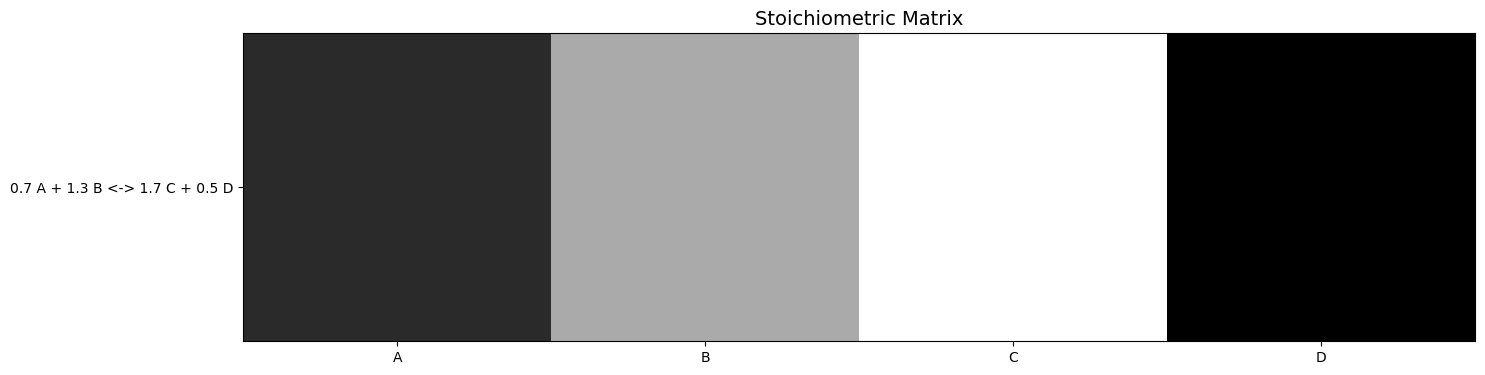


stoic_mtrx=
 [[-0.7 -1.3  1.7  0.5]]

mole balance vector =
 [0.2]


In [8]:
'''Info on data'''

import numpy as np
np.set_printoptions(precision=3,threshold=100,edgeitems=5)

print('species=',species_names)

from chen_3170.help import print_reactions
print('')
print_reactions(reactions) 
print('')

#keq_cte_vec = np.array([d['K_x'] for d in rxn_mech.data])
keq_cte = rxn_mech.data[0]['K_x']
print('K_x eq = ',keq_cte)
print('')

from chen_3170.help import plot_matrix
plot_matrix(stoic_mtrx, title='Stoichiometric Matrix', xlabels=species_names, ylabels=reactions, xrotation=0)
print('')
np.set_printoptions(precision=3,threshold=100,edgeitems=5)
print('stoic_mtrx=\n',stoic_mtrx)
print('')
print('mole balance vector =\n', stoic_mtrx.sum(1))

In [9]:
'''Parameters'''

x_a_0 = 0.5
x_b_0 = 0.5
x_c_0 = 0.0
x_d_0 = 0.0

x_vec_0 = np.array([x_a_0, x_b_0, x_c_0, x_d_0])

# Sanity check
assert abs(np.sum(x_vec_0) - 1.0) <= 1e-12
assert np.all(x_vec_0 >=0.0) and keq_cte >= 0

Rigorous bounds on the normalized extent of reaction, $\widehat{\varepsilon}$. For product species:

\begin{equation*}
  \widehat{\varepsilon} \ge \max\Bigl(\frac{- x_j^{(0)}}{\abs{S^\top_{j,1}}}\Bigr) \ \quad\quad \forall \ \quad\quad j \ \quad S^\top_{j,1} > 0.
\end{equation*}

For reactant species:

\begin{equation*}
  \widehat{\varepsilon} \le \min\Bigl(\frac{x_j^{(0)}}{\abs{S^\top_{j,1}}}\Bigr) \ \quad\quad \forall \ \quad\quad j \ \quad S^\top_{j,1} < 0.
\end{equation*}

In [10]:
'''Bounds on extent of reaction'''

def bounds_epsilon_hat(x_vec_0, stoic_mtrx):
    stoic_row = stoic_mtrx[0,:]

    (ids,) = np.where(stoic_row > 0) # products
    ext_hat_min = np.max(-x_vec_0[ids]/np.abs(stoic_row[ids]))

    (ids,) = np.where(stoic_row < 0) # reactants
    ext_hat_max = np.min(x_vec_0[ids]/np.abs(stoic_row[ids]))

# reduce the ends of the interval by 0.5% to avoid infinite values in the equilibrium function
    dext = (ext_hat_max - ext_hat_min)*.005
    ext_hat_min += dext
    ext_hat_max -= dext
    
    return (ext_hat_min, ext_hat_max)

In [11]:
'''Bounds on extent of reaction'''

(ext_hat_min, ext_hat_max) = bounds_epsilon_hat(x_vec_0, stoic_mtrx)

print('ext_hat_min = %+1.3e'%ext_hat_min)
print('ext_hat_max = %+1.3e'%ext_hat_max)

ext_hat_min = +1.923e-03
ext_hat_max = +3.827e-01


### [Plot Equilibrium Function 1](#toc)<a id="pef1"></a>

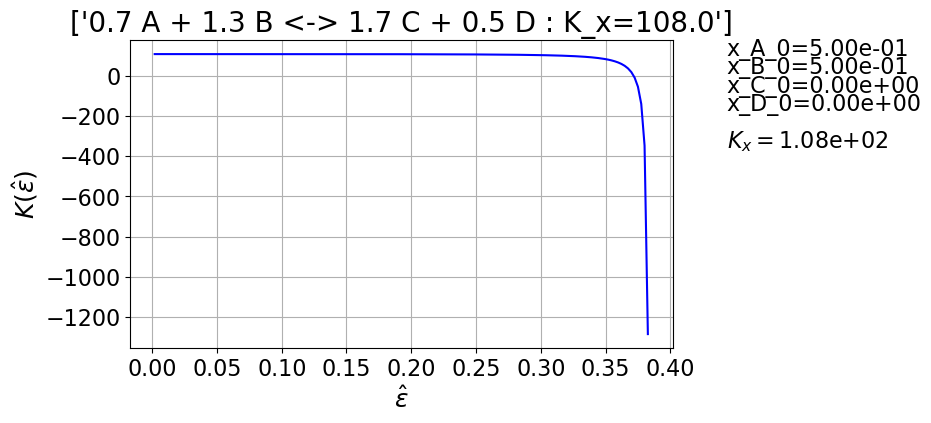

In [12]:
'''Plot equilibrium function'''

n_pts = 150

plot_keq_function(ext_hat_min, ext_hat_max, n_pts, 
                  x_vec_0, keq_cte, stoic_mtrx)

### [Solve for Equilibrium 1](#toc)<a id="solve1"></a>

In [13]:
'''Find root'''

ext_hat_0 = (ext_hat_max + ext_hat_min)/2.0

k_max = 20
tolerance = 1.0e-8

ext_hat = newton_solve(x_vec_0, keq_cte, stoic_mtrx,
                       ext_hat_0, k_max, tolerance)



*************************************************************
          Newton's Method Iterations                         
*************************************************************
k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|damped|
-------------------------------------------------------------
 1 +1.065e+02 -2.106e+03 +5.101e-02  +2.433e-01  0.00      0
 2 +1.036e+02 -2.127e+03 +5.007e-02  +2.934e-01  1.01      0
 3 +9.441e+01 -2.524e+03 +4.105e-02  +3.344e-01  1.07      0
 4 +6.588e+01 -3.704e+03 +2.549e-02  +3.599e-01  1.15      0
 5 +1.796e+01 -6.558e+03 +1.005e-02  +3.700e-01  1.25      0
 6 +6.315e-01 -1.045e+04 +1.719e-03  +3.717e-01  1.38      0
 7 +6.313e-04 -1.172e+04 +5.386e-05  +3.718e-01  1.54      0
 8 +6.259e-10 -1.177e+04 +5.363e-08  +3.718e-01  1.70      0
 9 +5.684e-14 -1.177e+04 +5.318e-14  +3.718e-01  1.83      0
*************************************************************
Root = 3.71752e-01


In [14]:
'''Compute equilibrium molar fractions'''

x_vec = molar_fractions(ext_hat, x_vec_0, stoic_mtrx)

print('')
print('Equilibrium mole fractions:\n')
for (x,spc) in zip(x_vec, species_names):
    print('x_%s = %5.3e (%4.1f%%)'%(spc,x,round(x*100,1)))

# Consistency check
assert np.all(x_vec >= 0.0)
assert abs(x_vec.sum() - 1.0) <= 1e-10


Equilibrium mole fractions:

x_A = 2.232e-01 (22.3%)
x_B = 1.557e-02 ( 1.6%)
x_C = 5.882e-01 (58.8%)
x_D = 1.730e-01 (17.3%)


### [Plot Equilibrium Point 1](#toc)<a id="pep1"></a>

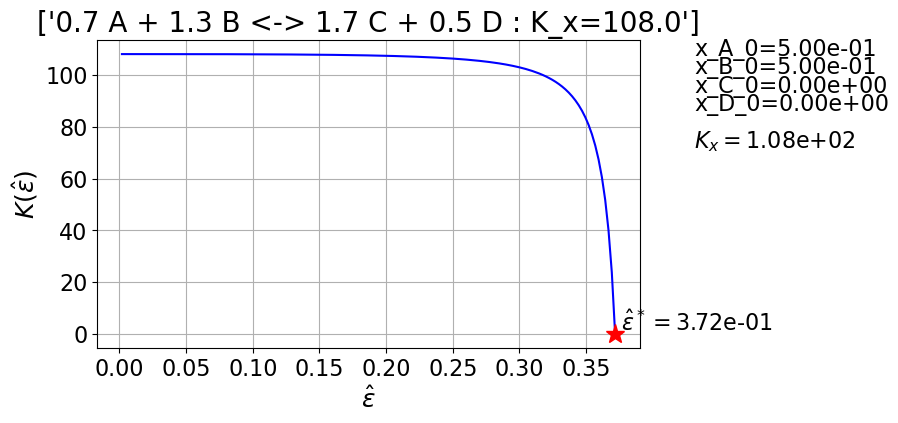

In [15]:
'''Plot equilibrium function with root'''

n_pts = 150

plot_keq_function(ext_hat_min, ext_hat, n_pts, 
                  x_vec_0, keq_cte, stoic_mtrx, ext_hat)

## [Input Data 2](#toc)<a id="data2"></a>

Reversible reaction: 
$\nu_A\,\text{A} + \nu_B\,\text{B} \overset{K_x}{\longleftrightarrow} \nu_C\,\text{C} + \nu_D\,\text{D}$ 

Name                        | Parameter    | Value | Name     | Parameter | Value |
----------------------------|--------------|-------|----------|-----------|-------|
initial mole fraction of A  | $x_{A_0}$    | 0.22  | stoic. A | $\nu_A$   |  0.7  |
initial mole fraction of B  | $x_{B_0}$    | 0.51  | stoic. B | $\nu_B$   |  1.3  |
initial mole fraction of C  | $x_{C_0}$    | 0.17  | stoic. C | $\nu_C$   |  1.7  |
initial mole fraction of C  | $x_{D_0}$    | 0.10  | stoic. D | $\nu_D$   |  0.5  |
mole equilibrium constant   | $K_\text{x}$ | 108   |    -     |     -     |   -   |

In [16]:
'''Parameters'''

x_a_0 = 0.22
x_b_0 = 0.51
x_c_0 = 0.17
x_d_0 = 0.10

x_vec_0 = np.array([x_a_0, x_b_0, x_c_0, x_d_0])

# Sanity check
assert abs(np.sum(x_vec_0) - 1.0) <= 1e-12
assert np.all(x_vec_0 >=0.0) and keq_cte >= 0

In [17]:
'''Bounds on extent of reaction'''

(ext_hat_min, ext_hat_max) = bounds_epsilon_hat(x_vec_0, stoic_mtrx)

print('ext_hat_min = %+1.3e'%ext_hat_min)
print('ext_hat_max = %+1.3e'%ext_hat_max)

ext_hat_min = -9.793e-02
ext_hat_max = +3.122e-01


### [Plot Equilibrium Function 2](#toc)<a id="pef2"></a>

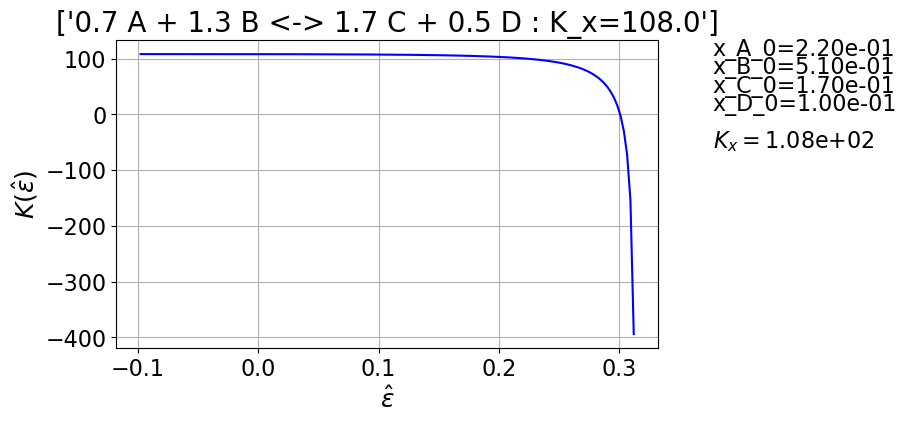

In [18]:
'''Plot equilibrium function'''

n_pts = 150

plot_keq_function(ext_hat_min, ext_hat_max, n_pts, 
                  x_vec_0, keq_cte, stoic_mtrx)

### [Solve for Equilibrium 2](#toc)<a id="solve2"></a>

In [19]:
'''Find root'''

ext_hat_0 = (ext_hat_max + ext_hat_min)/2.0

k_max = 20
tolerance = 1.0e-8

ext_hat = newton_solve(x_vec_0, keq_cte, stoic_mtrx,
                       ext_hat_0, k_max, tolerance)



*************************************************************
          Newton's Method Iterations                         
*************************************************************
k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|damped|
-------------------------------------------------------------
 1 +1.055e+02 -1.915e+03 +5.590e-02  +1.630e-01  0.00      0
 2 +1.009e+02 -1.955e+03 +5.397e-02  +2.170e-01  1.01      0
 3 +8.725e+01 -2.283e+03 +4.420e-02  +2.612e-01  1.07      0
 4 +5.202e+01 -3.117e+03 +2.799e-02  +2.892e-01  1.15      0
 5 +8.533e+00 -4.955e+03 +1.050e-02  +2.997e-01  1.27      0
 6 +8.611e-02 -7.266e+03 +1.174e-03  +3.009e-01  1.48      0
 7 +7.317e-06 -7.738e+03 +1.113e-05  +3.009e-01  1.69      0
 8 +7.105e-14 -7.743e+03 +9.450e-10  +3.009e-01  1.82      0
*************************************************************
Root = 3.00895e-01


In [20]:
'''Compute the equilibrium molar fractions'''

x_vec = molar_fractions(ext_hat, x_vec_0, stoic_mtrx)

print('')
print('Equilibrium mole fractions:\n')
for (x,spc) in zip(x_vec,species_names):
    print('x_%s = %5.3e (%4.1f%%)'%(spc,x,round(x*100,1)))

# Check for consistency
assert np.all(x_vec >= 0.0)
assert abs(x_vec.sum() - 1.0) <= 1e-10


Equilibrium mole fractions:

x_A = 8.842e-03 ( 0.9%)
x_B = 1.121e-01 (11.2%)
x_C = 6.428e-01 (64.3%)
x_D = 2.362e-01 (23.6%)


### [Plot Equilibrium Point 2](#toc)<a id="pep2"></a>

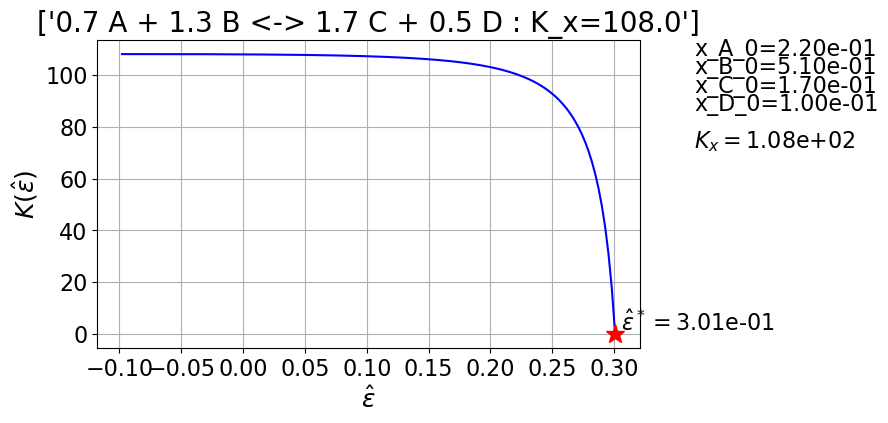

In [21]:
'''Plot equilibrium function with root'''

n_pts = 150

plot_keq_function(ext_hat_min, ext_hat, n_pts, 
                  x_vec_0, keq_cte, stoic_mtrx, ext_hat)

## [Input Data 3](#toc)<a id="data3"></a>

Reversible reaction: 
$\nu_A\,\text{A} + \nu_B\,\text{B} \overset{K_x}{\longleftrightarrow} \nu_C\,\text{C} + \nu_D\,\text{D}$ 

Name                        | Parameter    | Value | Name     | Parameter | Value |
----------------------------|--------------|-------|----------|-----------|-------|
initial mole fraction of A  | $x_{A_0}$    | 0.07  | stoic. A | $\nu_A$   |  1.7  |
initial mole fraction of B  | $x_{B_0}$    | 0.11  | stoic. B | $\nu_B$   |  2.3  |
initial mole fraction of C  | $x_{C_0}$    | 0.32  | stoic. C | $\nu_C$   |  0.2  |
initial mole fraction of C  | $x_{D_0}$    | 0.50  | stoic. D | $\nu_D$   |  1.5  |
mole equilibrium constant   | $K_\text{x}$ | 120   |    .     |  .        |  .    |

In [22]:
'''Reaction mechanism'''

try:
    from chen_3170.toolkit import reaction_mechanism   
except ModuleNotFoundError:
    assert False, 'You need to provide your own reaction_mechanism function here. Bailing out.'

reaction = ['1.7 A + 2.3 B <-> 0.2 C + 1.5 D : K_x=120.0']
(species_names, reactions, stoic_mtrx, rxn_mech) = reaction_mechanism(reactions=reaction)

species= ['A', 'B', 'C', 'D']

r0 :  1.7 A + 2.3 B <-> 0.2 C + 1.5 D
n_reactions = 1

K_x eq =  [120.]

matrix shape = (1, 4)


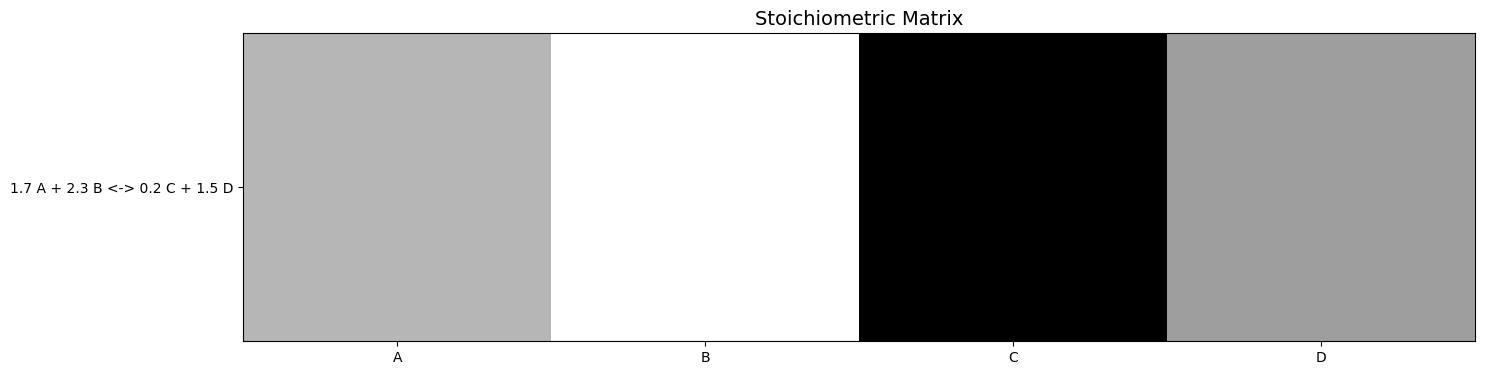


stoic_mtrx=
 [[-1.7 -2.3  0.2  1.5]]

mole balance vector =
 [-2.3]


In [23]:
'''Info on data'''

import numpy as np
np.set_printoptions(precision=3,threshold=100,edgeitems=5)

print('species=',species_names)

from chen_3170.help import print_reactions
print('')
print_reactions(reactions) 
print('')

keq_cte_vec = np.array([d['K_x'] for d in rxn_mech.data])
print('K_x eq = ',keq_cte_vec)
print('')

from chen_3170.help import plot_matrix
plot_matrix(stoic_mtrx, title='Stoichiometric Matrix', xlabels=species_names, ylabels=reactions, xrotation=0)
print('')
np.set_printoptions(precision=3,threshold=100,edgeitems=5)
print('stoic_mtrx=\n',stoic_mtrx)
print('')
print('mole balance vector =\n', stoic_mtrx.sum(1))

In [24]:
'''Parameters'''

x_a_0 = 0.07
x_b_0 = 0.11
x_c_0 = 0.32
x_d_0 = 0.50

x_vec_0 = np.array([x_a_0, x_b_0, x_c_0, x_d_0])

# Sanity check
assert abs(np.sum(x_vec_0) - 1.0) <= 1e-12
assert np.all(x_vec_0 >=0.0) and keq_cte >= 0

In [25]:
'''Bounds on extent of reaction'''

(ext_hat_min, ext_hat_max) = bounds_epsilon_hat(x_vec_0, stoic_mtrx)

print('ext_hat_min = %+1.3e'%ext_hat_min)
print('ext_hat_max = %+1.3e'%ext_hat_max)

ext_hat_min = -3.315e-01
ext_hat_max = +3.930e-02


### [Plot Equilibrium Function 3](#toc)<a id="pef3"></a>

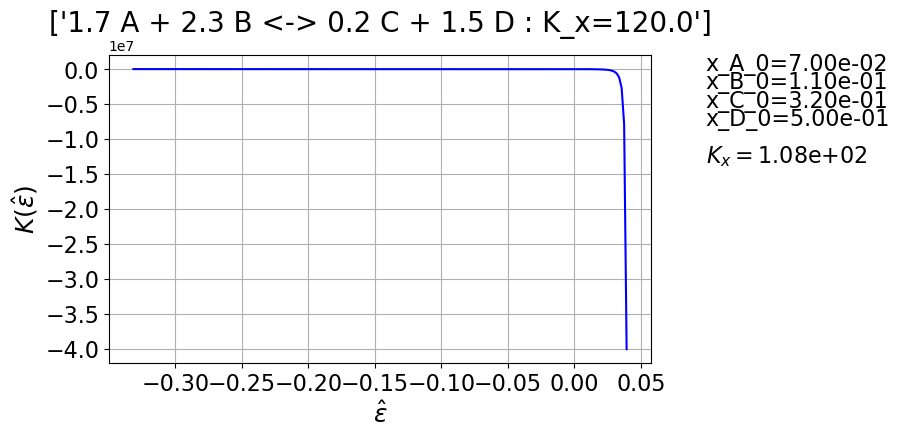

In [26]:
'''Plot equilibrium function'''

n_pts = 200

plot_keq_function(ext_hat_min, ext_hat_max, n_pts, 
                  x_vec_0, keq_cte, stoic_mtrx)

### [Solve for Equilibrium 3](#toc)<a id="solve3"></a>

In [27]:
'''Find root and equilibrium molar fractions'''

ext_hat_0 = (ext_hat_max + ext_hat_min)/2.0

k_max = 20
tolerance = 1.0e-8

ext_hat = newton_solve(x_vec_0, keq_cte, stoic_mtrx,
                       ext_hat_0, k_max, tolerance)



*************************************************************
          Newton's Method Iterations                         
*************************************************************
k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|damped|
-------------------------------------------------------------
 1 +8.153e+01 -2.714e+03 +3.606e-02  -1.100e-01  0.00      0
 2 +4.858e+01 -3.072e+03 +2.654e-02  -8.348e-02  1.09      0
 3 +1.280e+01 -3.548e+03 +1.369e-02  -6.979e-02  1.18      0
 4 +6.600e-01 -3.903e+03 +3.280e-03  -6.651e-02  1.33      0
 5 +1.595e-03 -4.003e+03 +1.649e-04  -6.635e-02  1.52      0
 6 +9.277e-09 -4.008e+03 +3.980e-07  -6.635e-02  1.69      0
 7 -1.421e-14 -4.008e+03 +2.314e-12  -6.635e-02  1.82      0
*************************************************************
Root = -6.63450e-02


**Note negative extent of reaction at equilibrium. Compare the equilibrium molar fractions to the initial molar fractions.**

In [28]:
'''Compute equilibrium molar fractions'''

x_vec = molar_fractions(ext_hat, x_vec_0, stoic_mtrx)

print('')
print('Equilibrium mole fractions:\n')
for (x,spc) in zip(x_vec,species_names):
    print('x_%s = %5.3e (%4.1f%%)'%(spc,x,round(x*100,1)))
    
assert np.all(x_vec >= 0.0)
assert abs(x_vec.sum() - 1.0) <= 1e-10


Equilibrium mole fractions:

x_A = 1.586e-01 (15.9%)
x_B = 2.278e-01 (22.8%)
x_C = 2.661e-01 (26.6%)
x_D = 3.475e-01 (34.7%)


### [Plot Equilibrium Point 3](#toc)<a id="pep3"></a>

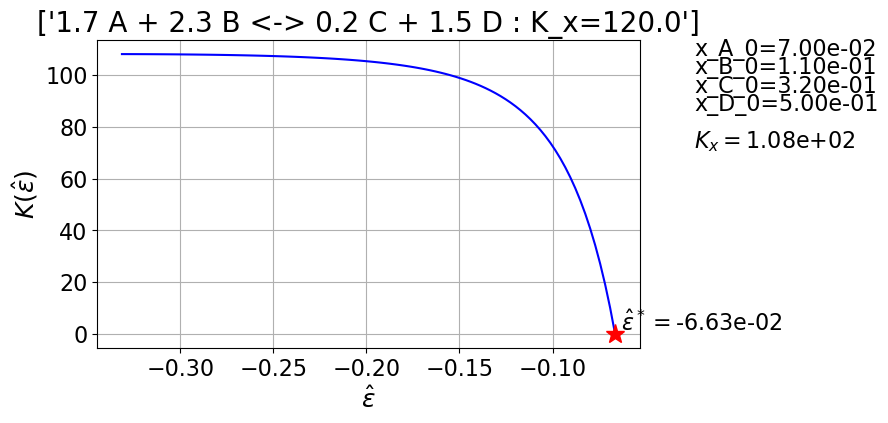

In [29]:
'''Plot equilibrium function with root'''

n_pts = 100

plot_keq_function(ext_hat_min, ext_hat, n_pts, 
                  x_vec_0, keq_cte, stoic_mtrx, ext_hat)